# Late Fusion Model for Outcome Classification

This notebook implements late fusion combining:
- **Physiological data** (pupil metrics)
- **Behavioral data** (reaction time, decision time, etc.)
- **Gaze data** (gaze position, movements, fixations)

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

Goals:
1. Train separate models for each modality
2. Implement late fusion (stacking/weight averaging)
3. Extract weights to estimate modality influence on predictions

In [ ]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../..')  # Add project root to path

import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.utils.io import load_features, save_results
from src.utils.config import get_model_params, load_config
from src.utils.validation import validate_features, validate_modality_features
from src.models.fusion import weighted_late_fusion
from src.visualization.plots import (
    plot_method_comparison,
    plot_modality_weights,
    set_style
)

np.random.seed(42)
set_style('whitegrid')  # Use shared style function

print(f"\n{'='*70}")
print(f"LATE FUSION ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


LATE FUSION ANALYSIS: PRE-DECISION PERIOD



## 1. Load Pre-Extracted Features

In [8]:
# Load configuration
config = load_config('model_params')
time_window = config['time_windows'][f'{TIMEFRAME.lower()}_decision']

print(f"Time window: {time_window['start']}s to {time_window['end']}s")
print(f"Description: {time_window['description']}\n")

# Load pre-extracted features
features_path = f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

# Validate loaded features
validate_features(merged_df, timeframe=TIMEFRAME)

print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
if 'baseline_method' in feature_data['metadata']:
    print(f"  Baseline method: {feature_data['metadata']['baseline_method']}")
print(f"\nFeature counts:")
print(f"  Physiology ({TIMEFRAME}): {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")

Time window: -2.0s to 0.0s
Description: Anticipatory period before submit button

✓ Validation passed (PRE): 12511 trials, 97 subjects
  Trials per subject: min=9, max=246, mean=129.0
  Outcome balance: 4273 keep / 8238 invest
  Features extracted on: 2026-01-01 17:53:05
  Baseline method: t3_stable_pre_decision

Feature counts:
  Physiology (PRE): 13 features
  Behavior: 7 features
  Gaze: 20 features


## 2. Prepare Feature Sets

In [9]:
# Prepare feature arrays for model training
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])

# Handle gaze features (may be empty in POST)
if len(gaze_cols) > 0:
    X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
else:
    # Create placeholder array for POST condition (no gaze data)
    X_gaze = np.zeros((len(merged_df), 1))

y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Shapes: X_physio={X_physio.shape}, X_behavior={X_behavior.shape}, X_gaze={X_gaze.shape}")

Shapes: X_physio=(12511, 13), X_behavior=(12511, 7), X_gaze=(12511, 20)


In [10]:
def train_evaluate_modality(X, y, subjects, modality_name):
    """
    Train and evaluate a single modality using LOSO cross-validation.
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix for the modality, shape (n_samples, n_features)
    y : np.ndarray
        Target labels, shape (n_samples,)
    subjects : np.ndarray
        Subject IDs for each sample, shape (n_samples,)
    modality_name : str
        Name of the modality (for display purposes)
    
    Returns
    -------
    tuple
        (model, accuracy, f1_score, predictions, y_true)
        - model: Last trained RandomForestClassifier
        - accuracy: Mean accuracy across subjects
        - f1_score: Mean F1-score across subjects
        - predictions: All predictions concatenated
        - y_true: All true labels concatenated
    """
    logo = LeaveOneGroupOut()
    
    # Get model parameters from config
    model_params = get_model_params('random_forest')
    
    # Initialize storage
    all_preds = []
    all_y_true = []
    subject_accs = []
    subject_f1s = []
    
    print(f"\n{'='*50}")
    print(f"{modality_name} Model")
    print(f"{'='*50}")
    
    # LOSO cross-validation
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model
        model = RandomForestClassifier(**model_params)
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store results
        all_preds.extend(y_pred)
        all_y_true.extend(y_test)
        
        # Subject-level metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs.append(acc)
        subject_f1s.append(f1)
    
    # Calculate overall metrics
    overall_acc = np.mean(subject_accs)
    overall_f1 = np.mean(subject_f1s)
    
    print(f"Accuracy: {overall_acc:.3f} ± {stats.sem(subject_accs):.3f}")
    print(f"F1-Score: {overall_f1:.3f} ± {stats.sem(subject_f1s):.3f}")
    print(f"N subjects: {len(subject_accs)}")
    
    return model, overall_acc, overall_f1, np.array(all_preds), np.array(all_y_true)

## 3. Train Individual Modality Models

In [11]:
model_physio, acc_physio, f1_physio, pred_physio, y_true = train_evaluate_modality(
    X_physio, y, subjects, "Physiology"
)
model_behavior, acc_behavior, f1_behavior, pred_behavior, _ = train_evaluate_modality(
    X_behavior, y, subjects, "Behavior"
)

# Only train gaze model if gaze data exists
if len(gaze_cols) > 0:
    model_gaze, acc_gaze, f1_gaze, pred_gaze, _ = train_evaluate_modality(
        X_gaze, y, subjects, "Gaze"
    )
else:
    # Placeholder for POST (no gaze data)
    model_gaze = None
    acc_gaze = 0.5
    f1_gaze = 0.5
    pred_gaze = np.zeros(len(y))
    print(f"\n{'='*50}\nGaze Model\n{'='*50}")
    print("Skipping - no gaze data available (POST condition)")


Physiology Model
Accuracy: 0.519 ± 0.014
F1-Score: 0.504 ± 0.017
N subjects: 97

Behavior Model
Accuracy: 0.647 ± 0.014
F1-Score: 0.661 ± 0.015
N subjects: 97

Gaze Model
Accuracy: 0.503 ± 0.012
F1-Score: 0.505 ± 0.014
N subjects: 97


## 4. Late Fusion Implementation

Using shared `weighted_late_fusion` function from `src.models.fusion`.

In [12]:
# Run fusion methods
if len(gaze_cols) > 0:
    X_modalities = [X_physio, X_behavior, X_gaze]
    modality_names = ['Physiology', 'Behavior', 'Gaze']
else:
    # POST condition: no gaze data
    X_modalities = [X_physio, X_behavior]
    modality_names = ['Physiology', 'Behavior']

# Validate modalities before fusion
validate_modality_features(X_modalities, y, subjects, modality_names)

print("\nRunning fusion methods...")
results_avg = weighted_late_fusion(X_modalities, y, subjects, modality_names,
                                   fusion_method='average')
results_weighted = weighted_late_fusion(X_modalities, y, subjects, modality_names,
                                        fusion_method='weighted')
results_stacking = weighted_late_fusion(X_modalities, y, subjects, modality_names,
                                        fusion_method='stacking')

✓ Modality validation passed:
  Physiology: 12511 samples × 13 features
  Behavior: 12511 samples × 7 features
  Gaze: 12511 samples × 20 features

Running fusion methods...


## 5. Compare All Methods


PERFORMANCE COMPARISON (PRE)
         Method  Accuracy  F1-Score
Physiology Only  0.519080  0.504044
  Behavior Only  0.647486  0.660967
      Gaze Only  0.502747  0.504944
 Average Fusion  0.638032  0.639036
Weighted Fusion  0.678201  0.661893
       Stacking  0.624127  0.625939


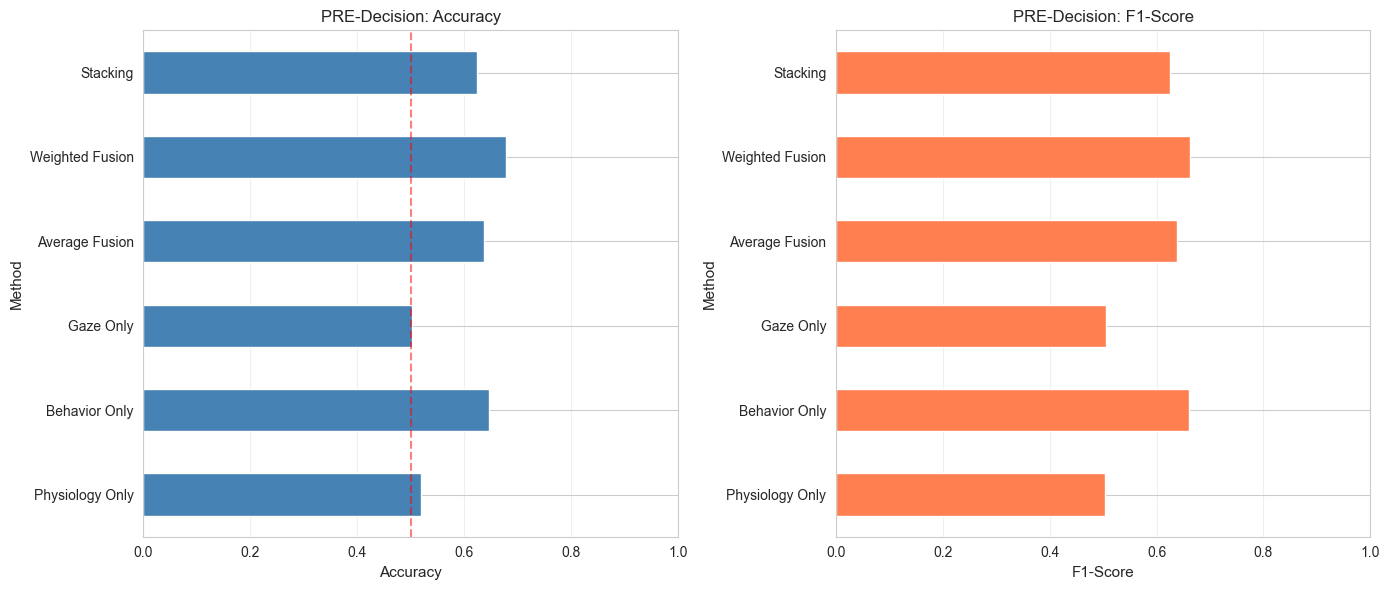

In [13]:
# Build comparison dataframe
comparison_data = {
    'Method': ['Physiology Only', 'Behavior Only'],
    'Accuracy': [acc_physio, acc_behavior],
    'F1-Score': [f1_physio, f1_behavior]
}

# Add gaze if available
if len(gaze_cols) > 0:
    comparison_data['Method'].append('Gaze Only')
    comparison_data['Accuracy'].append(acc_gaze)
    comparison_data['F1-Score'].append(f1_gaze)

# Add fusion methods
comparison_data['Method'].extend(['Average Fusion', 'Weighted Fusion', 'Stacking'])
comparison_data['Accuracy'].extend([
    results_avg['accuracy_mean'],
    results_weighted['accuracy_mean'],
    results_stacking['accuracy_mean']
])
comparison_data['F1-Score'].extend([
    results_avg['f1_mean'],
    results_weighted['f1_mean'],
    results_stacking['f1_mean']
])

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print(f"PERFORMANCE COMPARISON ({TIMEFRAME})")
print("="*70)
print(comparison_df.to_string(index=False))

# Use shared plotting function
fig = plot_method_comparison(comparison_df, timeframe=TIMEFRAME)
plt.show()

## 6. Summary

In [14]:
print("\n" + "="*70)
print(f"SUMMARY ({TIMEFRAME}-DECISION)")
print("="*70)

print("\n1. INDIVIDUAL MODALITIES:")
print(f"   Physiology:  Acc={acc_physio:.3f}, F1={f1_physio:.3f}")
print(f"   Behavior:    Acc={acc_behavior:.3f}, F1={f1_behavior:.3f}")
if len(gaze_cols) > 0:
    print(f"   Gaze:        Acc={acc_gaze:.3f}, F1={f1_gaze:.3f}")
else:
    print(f"   Gaze:        Not available (POST condition)")

print("\n2. LATE FUSION METHODS:")
print(f"   Average:     Acc={results_avg['accuracy_mean']:.3f}, F1={results_avg['f1_mean']:.3f}")
print(f"   Weighted:    Acc={results_weighted['accuracy_mean']:.3f}, F1={results_weighted['f1_mean']:.3f}")
print(f"   Stacking:    Acc={results_stacking['accuracy_mean']:.3f}, F1={results_stacking['f1_mean']:.3f}")

print("\n3. MODALITY CONTRIBUTIONS (Weighted Fusion):")
for name, w in zip(modality_names, results_weighted['weights']):
    print(f"   {name:12s}: {w*100:5.1f}%")

best = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"\n4. BEST METHOD: {best['Method']} (Acc={best['Accuracy']:.3f})")
print("\n" + "="*70)


SUMMARY (PRE-DECISION)

1. INDIVIDUAL MODALITIES:
   Physiology:  Acc=0.519, F1=0.504
   Behavior:    Acc=0.647, F1=0.661
   Gaze:        Acc=0.503, F1=0.505

2. LATE FUSION METHODS:
   Average:     Acc=0.638, F1=0.639
   Weighted:    Acc=0.678, F1=0.662
   Stacking:    Acc=0.624, F1=0.626

3. MODALITY CONTRIBUTIONS (Weighted Fusion):
   Physiology  :   0.0%
   Behavior    :   0.3%
   Gaze        :  99.7%

4. BEST METHOD: Weighted Fusion (Acc=0.678)



## 7. Modality Weights Visualization


MODALITY WEIGHTS (Influence on Prediction)
  Modality  Average  Weighted  Stacking
Physiology 0.333333  0.000490  0.193540
  Behavior 0.333333  0.002732  0.495755
      Gaze 0.333333  0.996778  0.310705


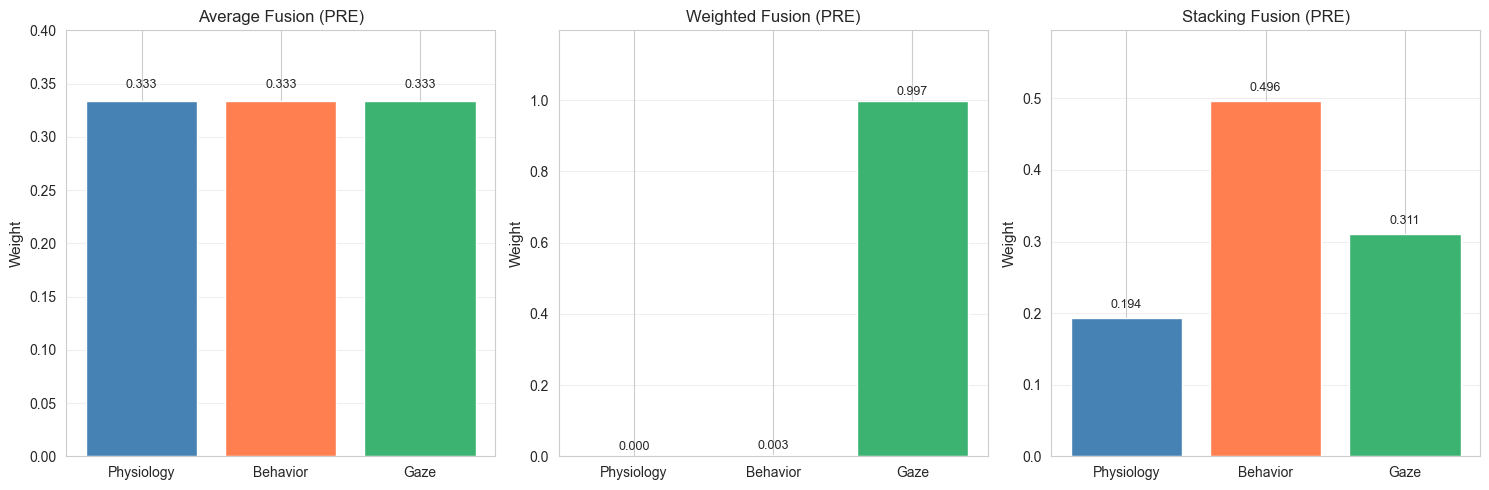

In [15]:
weights_df = pd.DataFrame({
    'Modality': modality_names,
    'Average': results_avg['weights'],
    'Weighted': results_weighted['weights'],
    'Stacking': results_stacking['weights']
})

print("\n" + "="*50)
print("MODALITY WEIGHTS (Influence on Prediction)")
print("="*50)
print(weights_df.to_string(index=False))

# Use shared plotting function
fig = plot_modality_weights(weights_df, timeframe=TIMEFRAME)
plt.show()

## 8. Save Results

In [16]:
# Save results using shared utility
import os
output_dir = f'../../data/results/fusion_model_results_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

# 1. Save method comparison results
save_results(comparison_df, 
             f'{output_dir}/late_fusion_model_{TIMEFRAME}_method_comparison.csv')

# 2. Save modality weights
save_results(weights_df,
             f'{output_dir}/late_fusion_model_{TIMEFRAME}_modality_weights.csv')

# 3. Save weighted fusion summary
weighted_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Accuracy_SEM', 'F1_Score', 'F1_SEM', 'N_Subjects', 'N_Trials'],
    'Value': [
        results_weighted['accuracy_mean'],
        results_weighted['accuracy_sem'],
        results_weighted['f1_mean'],
        results_weighted['f1_sem'],
        results_weighted['n_subjects'],
        results_weighted['n_trials']
    ]
})
save_results(weighted_summary,
             f'{output_dir}/late_fusion_model_{TIMEFRAME}_weighted_fusion_summary.csv')

# 4. Save subject-level accuracies
subject_df = pd.DataFrame({
    'subject_id': list(results_weighted['subject_accs'].keys()),
    'accuracy': list(results_weighted['subject_accs'].values())
})
save_results(subject_df,
             f'{output_dir}/late_fusion_model_{TIMEFRAME}_subject_accuracies.csv')
print(f"  - {len(subject_df)} subjects, Mean accuracy: {subject_df['accuracy'].mean():.4f}")

print(f"\n✓ All results saved to: {output_dir}/")

✓ Saved results to: ../../data/results/fusion_model_results_PRE/late_fusion_model_PRE_method_comparison.csv
✓ Saved results to: ../../data/results/fusion_model_results_PRE/late_fusion_model_PRE_modality_weights.csv
✓ Saved results to: ../../data/results/fusion_model_results_PRE/late_fusion_model_PRE_weighted_fusion_summary.csv
✓ Saved results to: ../../data/results/fusion_model_results_PRE/late_fusion_model_PRE_subject_accuracies.csv
  - 97 subjects, Mean accuracy: 0.6782

✓ All results saved to: ../../data/results/fusion_model_results_PRE/
